# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Import Libraries & load datasets

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import f1_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore the datasets

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head(10) 

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [4]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
portfolio.shape

(10, 6)

In [9]:
profile.shape

(17000, 5)

In [10]:
transcript.shape

(306534, 4)

In [11]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


## Cleaning the data

In [12]:
#extract all channels names 
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
channels_set    

{'email', 'mobile', 'social', 'web'}

In [13]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head() 

,channels,difficulty,duration,id,offer_type,reward,web,mobile,social,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [14]:
# drop the 'channels' column 
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,web,mobile,social,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [15]:
# number of null values profile
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
# replace nan with the avg in income column, and none with N/A in gender column
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [17]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [18]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,118,20170925,NA,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568
7,118,20171002,NA,68617ca6246f4fbc85e91a2a49552598,65404.991568
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000
9,118,20161122,NA,8974fc5686fe429db53ddde067b88302,65404.991568


In [20]:
# number of null values in transcript
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
# find different keys in value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
keys 

['offer id', 'amount', 'offer_id', 'reward']

In [22]:
# check value column and and put each key in seperated column
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [23]:
transcript.head(10)

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0,0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


In [24]:
# drop value column
transcript = transcript.drop('value', axis=1)
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


## Analyzing/Modeling Process

Questions to answer:
<ul>
    <li>What is the average income for Starbucks customers?</li>
    <li>What is the average age for Starbucks customers?</li>
    <li>What is the most common promotion?</li>
    <li>Which type of promotions each gender likes?</li>
</ul>

#### Question 1: What is the average income for Starbucks customers?

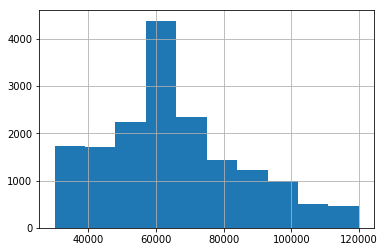

In [25]:
# distribution of income
profile.income.hist();

In [26]:
profile['income'].mean()

65404.991568296799

> After calculating the mean, I found that the average income for Starbucks customers is 65404.99. This could also be noticed from the above histogram.

#### Question 2: What is the average age for Starbucks customers?

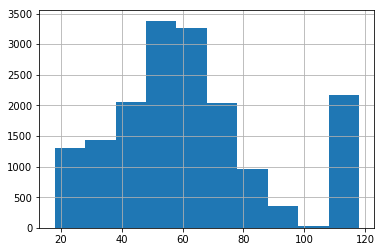

In [27]:
# age distribution
profile.age.hist();

> The above histogram shows the average age for Starbucks customers for all genders is 62.53.

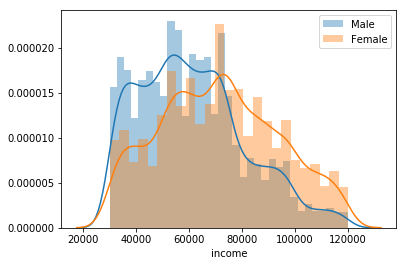

In [28]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

> The above chart shows the the average age for Starbucks customesr for each gender separately. As we can notice the average for females is higher than the average for males.

In [29]:
profile['age'].mean()

62.531411764705879

#### Question 3: What is the most common promotion?

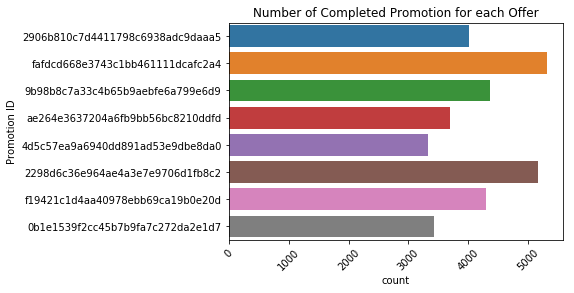

In [30]:
# We we check the completed orders only
completed_off_count = transcript[transcript['event'] == 'offer completed']
sns.countplot(y=completed_off_count['offer_id'])
plt.title('Number of Completed Promotion for each Offer')
plt.ylabel('Promotion ID')
plt.xticks(rotation = 45)
plt.show();

> The higher number of completed promotion was around 5500.

In [31]:
def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

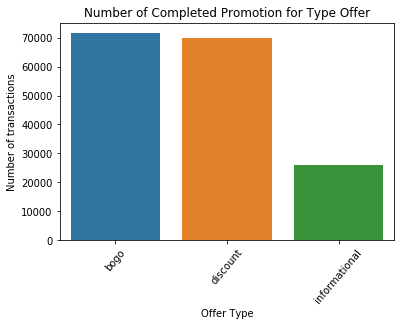

In [32]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50)
plt.show();

> From the above chart it is clear that, the number of completed promotion for the three types of offer, shows that Bogo and Discount close to each other, however Bogo is a slightly higher. 

#### Question 4: Which type of promotions each gender likes?

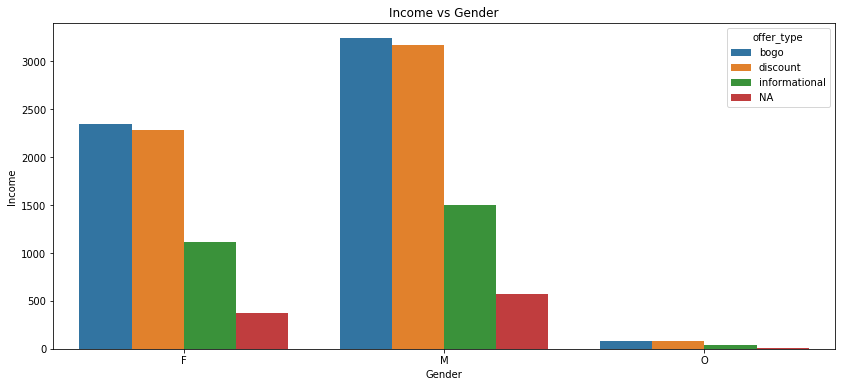

In [33]:
plt.figure(figsize=(14, 6))
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'], hue = 'offer_type', data=transcript)
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

> From the above chart it is clear that both male and female prefer Bogo from all types of promotions.

### Modeling Data

In this part, I built a machine learning model that predicts whether or not someone will respond to an offer.

In [34]:
# get transcripts with offer id's, because the model will guess the offer_type
transcript = transcript[transcript['offer_id'] != 'NA']

Here I needed to add gender and income to transcrip so I could use all what I need in one file

In [35]:
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

In [36]:
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [37]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,F,100000.000000
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,NA,65404.991568
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,M,70000.000000
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,NA,65404.991568
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,NA,65404.991568


Then I split the dataframe to features and target

In [38]:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

In [40]:
#get age group from profile dataframe
def get_customer_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_customer_age_group(x['person']), axis=1)

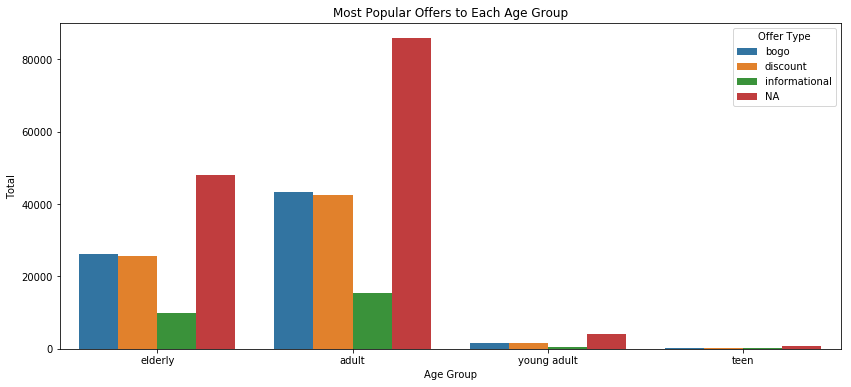

In [41]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue="offer_type", data=transcript)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

> The above chart shows the most popular offers to each age group. We have here some null values but most of the age groups like Bogo as we noticed before. Also, adults represents the highest group number among all other age groups.

In [42]:
# Features
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'adult': 1, 'elderly': 2, 'teen': 3, 'young adult': 4}}
{'gender': {'F': 1, 'M': 2, 'NA': 3, 'O': 4}}


In [43]:
# the target:
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [44]:
# replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)
transcript.replace(replace_map_comp_offer_type, inplace=True)

In [45]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,gender,income,age_group
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,8,0,0,2,1,100000.000000,2
1,2,a03223e636434f42ac4c3df47e8bac43,0,2,0,0,3,3,65404.991568,2
2,2,e2127556f4f64592b11af22de27a7932,0,4,0,0,3,2,70000.000000,2
3,2,8ec6ce2a7e7949b1bf142def7d0e0586,0,11,0,0,3,3,65404.991568,2
4,2,68617ca6246f4fbc85e91a2a49552598,0,6,0,0,2,3,65404.991568,2


In [46]:
# Split the data into features and target label
target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type'], axis = 1)

In [47]:
target.head()

0    2
1    3
2    3
3    3
4    2
Name: offer_type, dtype: int64

In [48]:
features.head()

,event,time,offer_id,amount,reward,gender,income,age_group
0,2,0,8,0,0,1,100000.000000,2
1,2,0,2,0,0,3,65404.991568,2
2,2,0,4,0,0,2,70000.000000,2
3,2,0,11,0,0,3,65404.991568,2
4,2,0,6,0,0,3,65404.991568,2


Then I normalized the numerical values (time, amount, reward, income) because I will use them as features.

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,offer_id,amount,reward,gender,income,age_group
0,2,0.0,8,0.0,0.0,1,0.777778,2
1,2,0.0,2,0.0,0.0,3,0.393389,2
2,2,0.0,4,0.0,0.0,2,0.444444,2
3,2,0.0,11,0.0,0.0,3,0.393389,2
4,2,0.0,6,0.0,0.0,3,0.393389,2


Creating training and testing sets

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [51]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (229900, 8)
Training Labels Shape: (229900,)
Testing Features Shape: (76634, 8)
Testing Labels Shape: (76634,)


### Metrics
I will use accuracy to evaluate the model since it is just a simple classification problem, I will compare the results of the models by comparing the number of correct predictions vs total number of predictions. The accuracy will help to get the ratio of the correctly labeled subjects to the whole pool of subjects. Also, it will help to answer the simple questions that listed above.
##### Accuracy = (TP+TN)/(TP+FP+FN+TN). 

#### Logistic Regression

In [52]:
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2) 

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 80.53%.
Prediction Accuracy: 92.81%


#### K-Nearest Neighbors

In [54]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### Decision Tree

In [55]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### Support Vector Machine

In [56]:
svm = SVC()
svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### Models Results

In [58]:
models = [logreg, knn, dt, svm]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [59]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC
Training Accuracy,80.526316,99.999565,100.0,100.0
Predicting Accuracy,92.810000,100.000000,100.0,100.0


Based on the above table, it is clear that I got 100% accourcy in DecisionTreeClassifier and SVC. To avoid overfitting I will choose Logistic Regression since it got good results 80.5% on training and 92.8% on testing datasets. Logistic Regression is better used here since we have few binomial outcomes ( BOGO = 2, discount = 3, informational = 4 ). It is good here because we have good amount of data to work with.

### Model Improvements

To improve the model I used the tuning technique to get better accuracy. Tuning is the process of maximizing a model's performance without overfitting or creating too high of a variance.

In [60]:
# Tuning to get better accuracy
dual = [True, False]
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.8230752501087429
Best params: {'C': 4.0, 'dual': True, 'max_iter': 140}


### Conclusion
In this project, I tried to analyze and make model to predict the best offer to give a Starbucks customer. First I explored the data and see what I have to change before start the analysis. Then I did some exploratory analysis on the data after cleaning. This process was very intersting as it helped me to answer some intersting questions about Starbucks.

<ul>Findings:
  <li>The average income for Starbucks customers is 65404.99.</li>
  <li>The average age for Starbucks customers for all genders is 62.53.</li>
  <li>the average for Starbucks customers for females is higher than the average for males.</li>
  <li>The higher number of completed promotion was around 5500.</li>
  <li>the number of completed promotion for the three types of offer, shows that Bogo and Discount close to each other, however Bogo is a slightly higher.</li>
  <li>Both male and female prefer Bogo from all types of promotions.</li>
  <li>Most of the age groups like Bogo.</li>
  <li>Adults represents the highest group number among all other age groups.</li>
</ul>


#### Future Improvements
For future impovments I will try to use more machine learning models and compare the results to the old models. Also, I would like to use more parameters to evaluate the models such as using Classification metrics and confusion matrixs. This will help to know if there is any wrong predactions. 

### References
<ul>
    <li>Handling Categorical Data in Python https://www.datacamp.com/community/tutorials/categorical-data</li>
    <li>Random Forest in Python https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 </li>
    <li>How to obtain only the name of a model's object in SciKitLearn? https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn/52768022#52768022</li>
</ul>